# I. Dependency of PTSD level from the Trauma set.

The variable "trauma" has 17 binary features "Yes" ↔ "No", and 66 observations.
Based on a processing method described at "SCORING PART 5 –TRAUMA SYMPTOMS DSM-V" we are of opinion that *PTSD level* is an **interval** variable.

In [1]:
import matplotlib
import scipy
import seaborn
import sklearn.linear_model
import statsmodels
from matplotlib.pyplot import hist, xlabel, ylabel, bar_label, scatter, title, xlim
from matplotlib import pyplot as plt
# Imports
from pandas import DataFrame, read_excel, options
from os.path import expanduser, join

from scipy import stats
from scipy.stats import f
from seaborn import set_style, color_palette, lmplot
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.utils import column_or_1d
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
# Gather Data
io: str = join(expanduser('~'), "Documents", "Data_Emigrant Study and APA.xlsx")

outcome: DataFrame    = read_excel(io=io, sheet_name='PTSD', header=0, index_col=0, usecols="A,GW", skiprows=[1])
y: DataFrame = outcome

predictors: DataFrame = read_excel(io=io,
                                   sheet_name='Harvard Trauma Questionnaire_MR',
                                   header=0,
                                   index_col=0,
                                   usecols="A, FQ, FS, FU, FW, FY, GA, GC, GE, GG, GI, GK, GM, GO, GQ, GS, GU, GW",
                                   skiprows=[1])
X: DataFrame = predictors

X = X.dropna(axis="rows", how="any")
y: DataFrame = y.dropna(axis="rows", how="any")

# Duplicates check, It is important!
# print(X[X.index.duplicated(keep=False)])
# print(y[y.index.duplicated(keep=False)])

# We will use only those observations that are present in both datasets.
y: DataFrame = y[y.index.isin(X.index)]
X: DataFrame = X[X.index.isin(y.index)]

# II. Data visualization

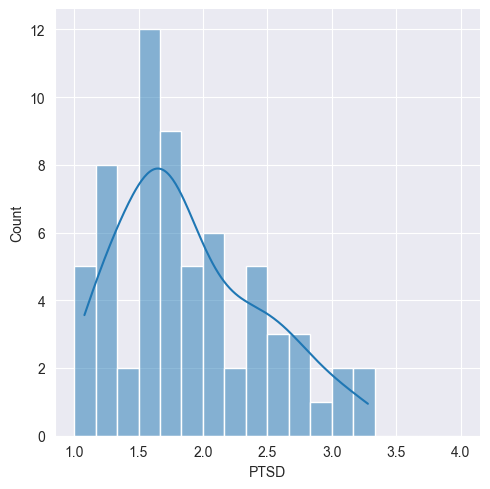

In [3]:
seaborn.displot(y['PTSD'], bins=18, kde=True, binrange=(1, 4))

We can see that the distribution is not normal. It is skewed to the left. Hypothetically, we can reduce the skewness by using the log transformation.

# III. Pairwise correlation of columns.

<Axes: >

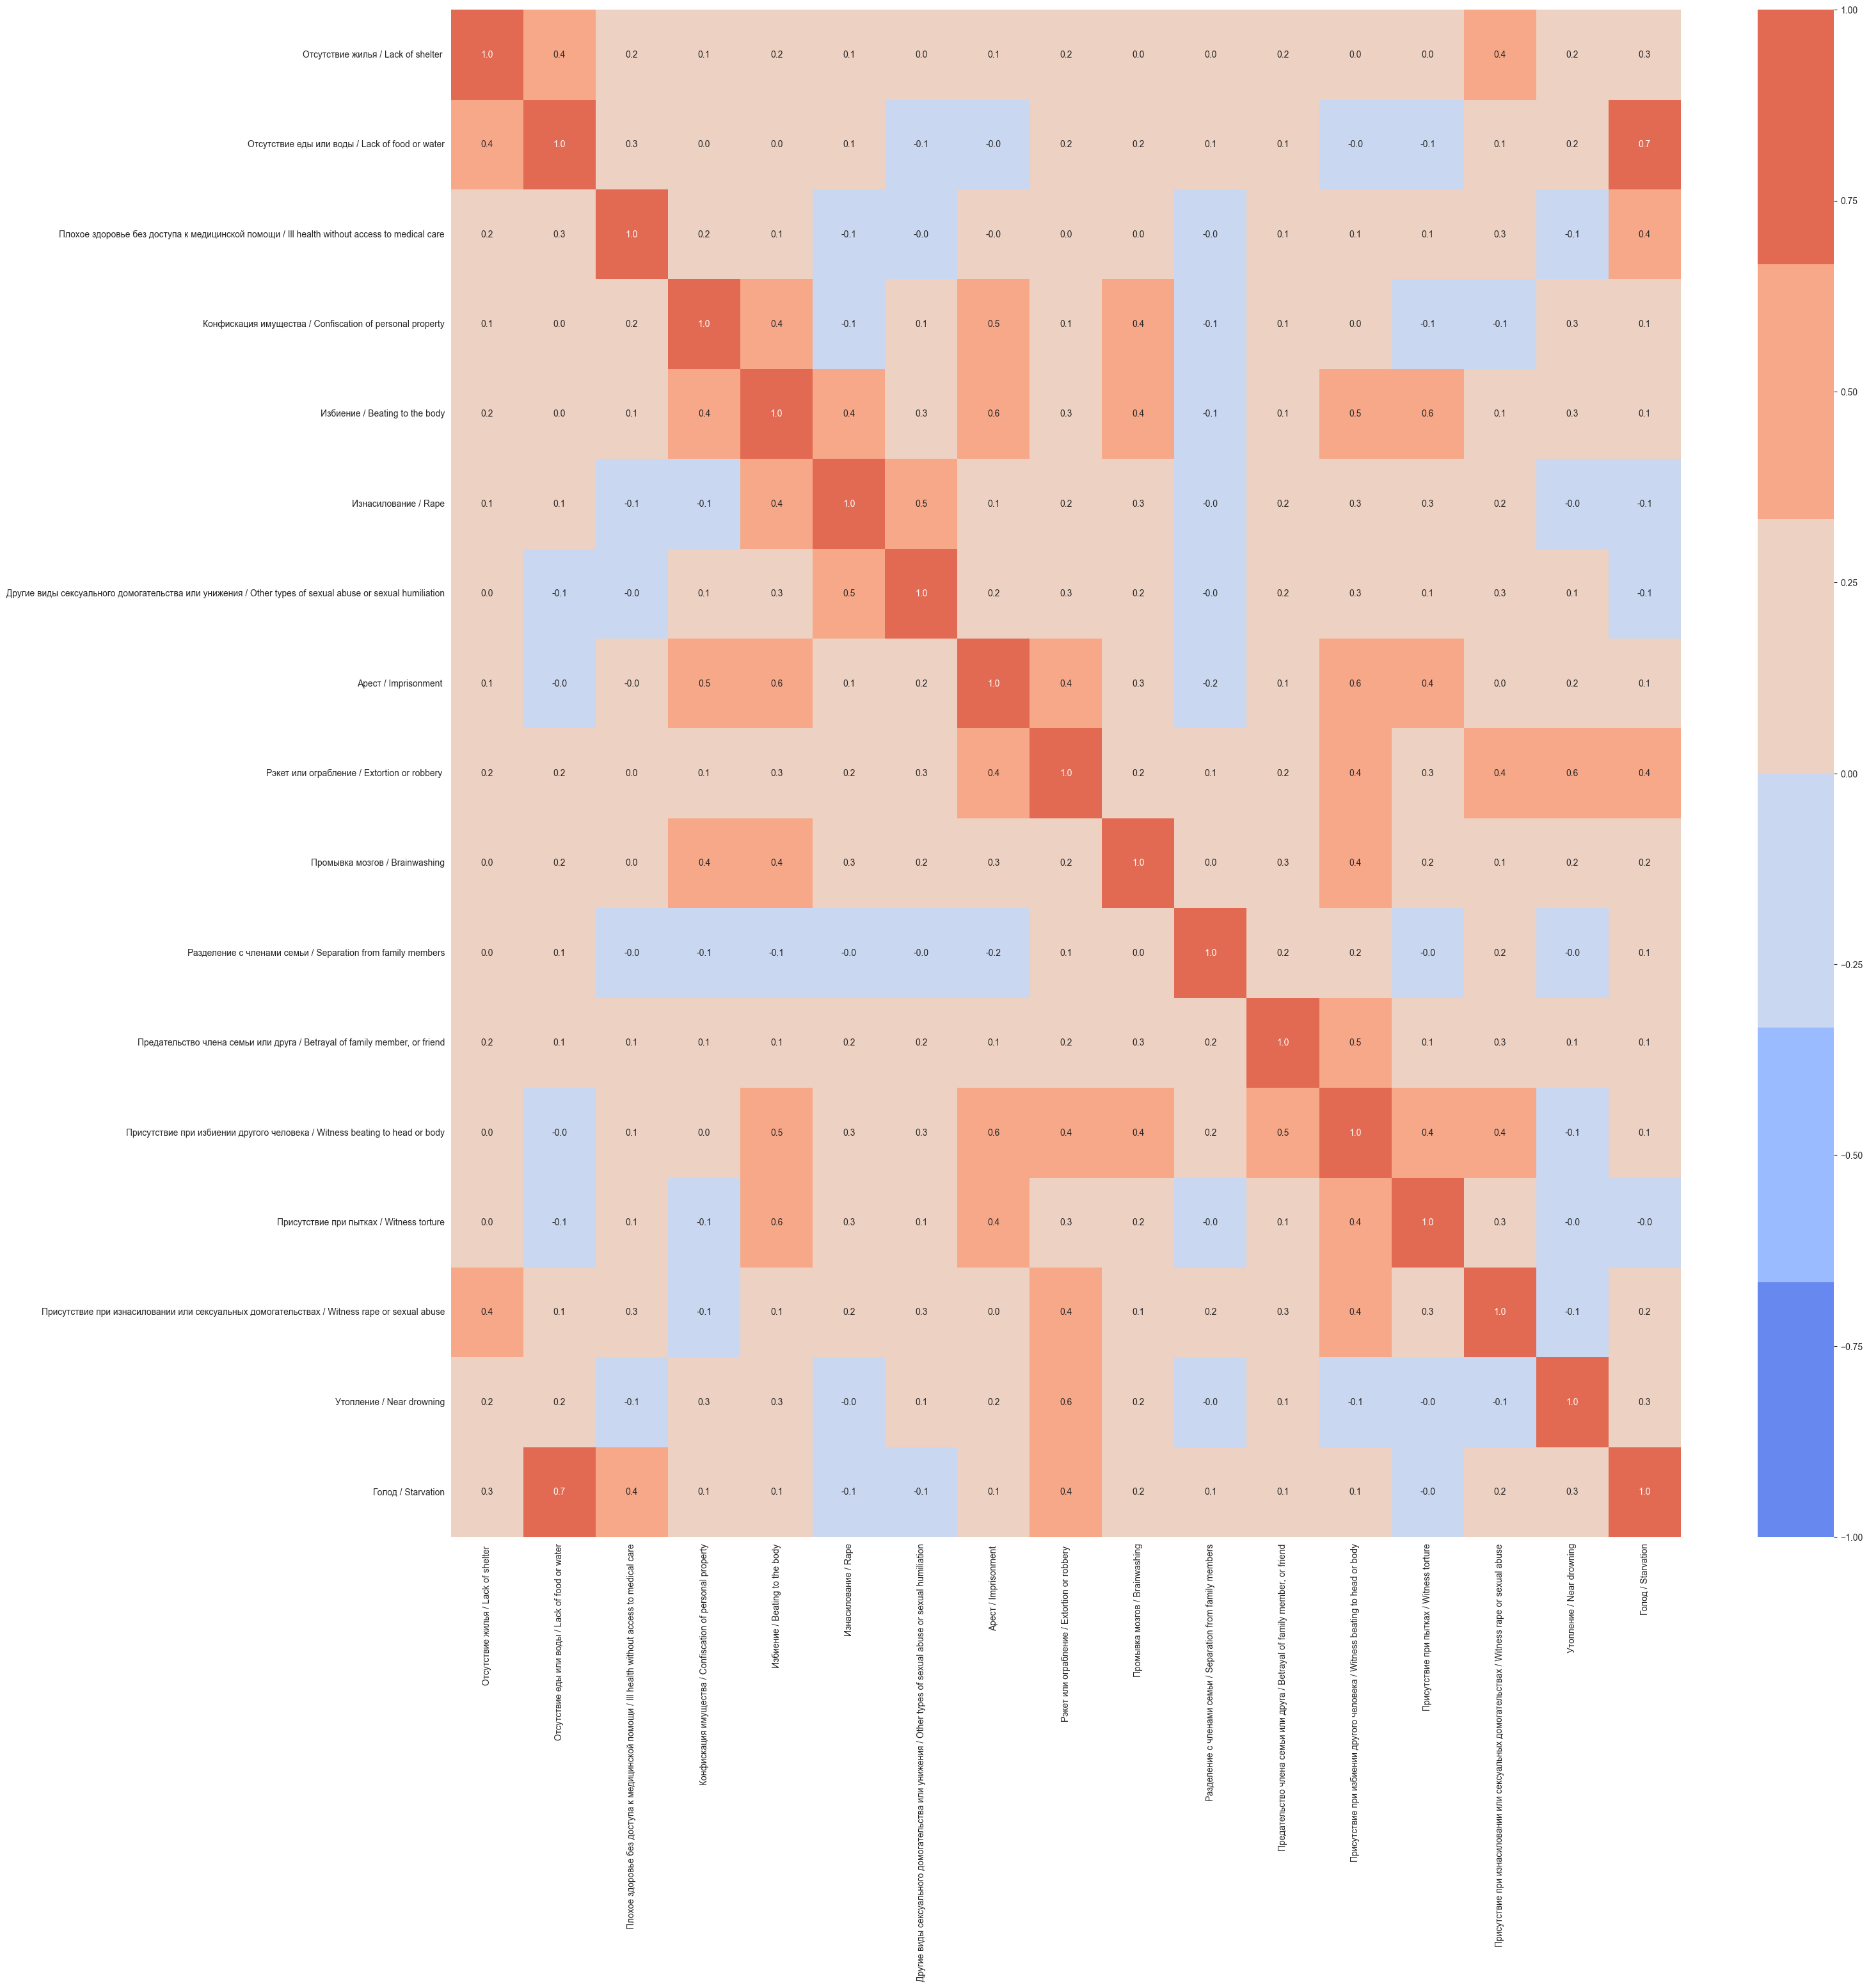

In [4]:
matplotlib.pyplot.figure(figsize=(31, 31))
seaborn.heatmap(X.corr(), annot=True, fmt='.1f', cmap=color_palette("coolwarm"), vmin=-1, vmax=1)
# set_style('white')

In [5]:
X['Голод / Starvation'].corr(X['Отсутствие еды или воды / Lack of food or water'])

0.6835298930947339

There is the collinearity between "Starvation" and "Lack of food or water". It meanas we have to remove one of them. Respondents cannot distinguish between these two concepts.

# IV. Data cleaning

In [6]:
# Из heatmap видно, что есть сильная корреляция между некоторыми признаками, поэтому удалим один из них.
X.drop(labels="Голод / Starvation", axis="columns", inplace=True)

# V. Stepwise Regression Implementation
## Step 6: Perform Stepwise Regression. sklearn implementation.

In [7]:
# Use SFS to perform stepwise feature selection
sfs = sklearn.feature_selection.SequentialFeatureSelector(estimator=sklearn.linear_model.LinearRegression(),
                                                          n_features_to_select=7,
                                                          direction='backward',
                                                          cv=5)
sfs.fit(X, y)

# Print the selected feature names
feature_names = sfs.get_feature_names_out()

## Step 7: Evaluate the Model with Selected Features


In [8]:
# Select the top features based on the selected indices
X_sfs = X.loc[:, feature_names]
# let add constant to X for intercept calculation
X_incl_const_sfs: DataFrame = add_constant(data=X_sfs)
# let create model for  Ordinary Least Squares (OLS)
model_sfs: statsmodels.regression.linear_model.OLS = statsmodels.regression.linear_model.OLS(endog=y, exog=X_incl_const_sfs)
# let fit model
results_sfs: statsmodels.regression.linear_model.RegressionResultsWrapper = model_sfs.fit()
print(f"Adjusted Coefficient of determination: {round(results_sfs.rsquared_adj, 2)}")  # Adjusted R-squared
print(f"Coefficient of determination: {round(results_sfs.rsquared, 2)}")  # R-squared
print(f"p-value (F-statistic): {round(results_sfs.f_pvalue, 6)}")  # p-value (F-statistic)

Adjusted Coefficient of determination: 0.16
Coefficient of determination: 0.25
p-value (F-statistic): 0.016502


# Table of features with less than 0.15 p-value in APA format.


In [9]:
estimate = results_sfs.params.rename('Estimate').to_frame()
ci = results_sfs.conf_int(alpha=0.05, cols=None).rename(columns={0: 'LL', 1: 'UL'})
se = results_sfs.bse.rename('SE')
p = results_sfs.pvalues.rename('p')
p = p[p <= 0.15]
options.display.float_format = '{:,.2f}'.format
estimate.join(other=[se, ci, p], on=None, how='inner')

,Estimate,SE,LL,UL,p
const,1.74,0.10,1.53,1.94,0.00
Отсутствие жилья / Lack of shelter,0.24,0.14,-0.05,0.52,0.10
Плохое здоровье без доступа к медицинской помощи / Ill health without access to medical care,0.38,0.17,0.04,0.72,0.03
Избиение / Beating to the body,0.43,0.29,-0.16,1.01,0.15


# VII. Charts of features with less than 0.15 p-value

In [10]:
# X_sfs.columns.tolist()

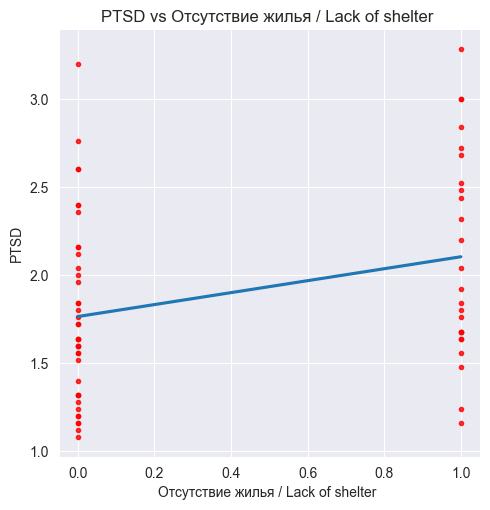

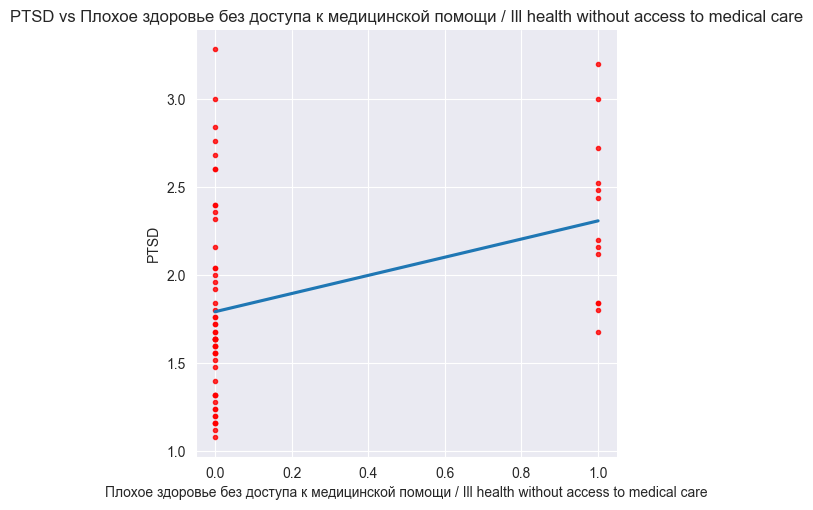

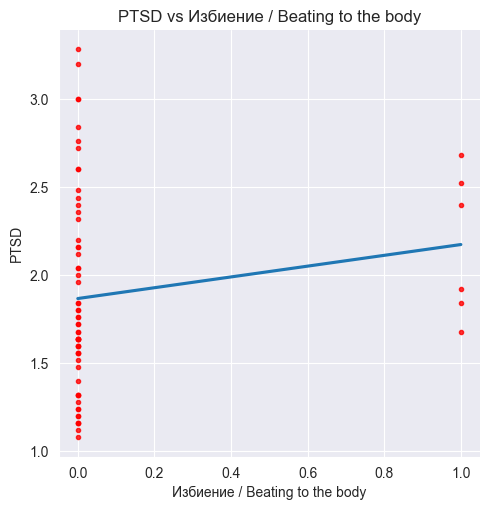

In [11]:
# Let's plot the charts of features with less than 0.15 p-value
for feature in X_sfs.columns.tolist():
    a = results_sfs.pvalues[feature]
    if results_sfs.pvalues[feature] <= 0.15:
        seaborn.lmplot(x=feature,
                       y='PTSD',
                       data=DataFrame(data={feature: X[feature],
                                        "PTSD": y["PTSD"]}),
                       order=1,
                       ci=None,
                       scatter_kws={'color': 'r', 's': 9})
        plt.title(f"PTSD vs {feature}")
        plt.xlabel(feature)
        plt.ylabel('PTSD')
        plt.show()